In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.utils import to_categorical
from preprocessing import *
import re
from tensorflow.keras.models import Model

In [28]:
data = pd.read_csv("C:\\Users\\User\\Downloads\\amazonfinereviews\\Reviews.csv")
data = data[0:2000]

In [29]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

In [30]:
text_data  = [str(i) for i in data['Text']]
summary_data  = [str(i) for i in data['Summary']]

data['Text'] = text_data
data['Summary'] = summary_data

We will perform the below preprocessing tasks for our data:

1.Convert everything to lowercase

2.Remove HTML tags

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside the parenthesis ( )

6.Eliminate punctuations and special characters

7.Remove stopwords

8.Remove short words

Let’s define the function:

In [31]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 
from bs4 import BeautifulSoup

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [32]:
#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0)) 

C:\Users\User\AppData\Local\Temp\ipykernel_7340\2551379146.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  newString = BeautifulSoup(newString, "lxml").text


In [33]:
cleaned_text[:5]  

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [34]:
#call the function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

C:\Users\User\AppData\Local\Temp\ipykernel_7340\2551379146.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  newString = BeautifulSoup(newString, "lxml").text


In [35]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [36]:
len(cleaned_text), len(cleaned_summary)

(1996, 1996)

In [37]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [38]:
# Drop empty rows
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

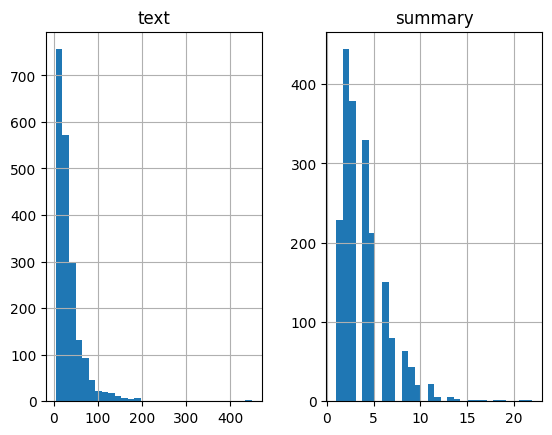

In [39]:
# Analyzing and Preparing the Data
# We will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text to 
# fix the maximum length of the sequence:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [40]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9468138484696438


In [41]:
# We observe that 94% of the summaries have length below 8. So, we can fix maximum length of summary to 8.
# Let us fix the maximum length of review to 30

In [42]:
max_text_len=30
max_summary_len=8

In [43]:
# Select the reviews and summaries whose length falls below or equal to max_text_len and max_summary_len
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [44]:
# We have to add the START and END special tokens at the beginning and end of the summary which does not appear anywhere in the summary.

In [45]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [46]:
data.shape, df.shape

((1993, 12), (1177, 2))

In [47]:
# Splitting the Data
# We split our dataset into a training and validation set. We’ll use 90% of the dataset as the training data and 10% as the validation set.
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

In [48]:
# Text Tokenizer
# A tokenizer builds the vocabulary and converts a word sequence to an integer sequence.

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [49]:
# Rarewords and its Coverage
# We are taking the threshold of 4 for rare words. We will find proportion and total coverage of rare words in entire text

thresh=4

cnt=0
tot_cnt=0 # Total Number of words
freq=0
tot_freq=0 # To occurance of words , example, if and occurs 2 times, the 3times then tot_freq is 5

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 73.9844184752365
Total Coverage of rare words: 19.76879222972973


In [50]:
cnt, tot_cnt, freq, tot_freq

(2659, 3594, 3745, 18944)

In [51]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [52]:
x_tr.shape, x_val.shape, x_voc

((1059, 30), (118, 30), 936)

In [53]:
# Summary Tokenizer

#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [54]:
# Here we are taking the threshold of 6 for rare words. We will find proportion and total coverage of rare words in entire text
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 89.7897897897898
Total Coverage of rare words: 25.33673097925009


In [55]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [56]:
y_tr.shape, y_val.shape, y_voc

((1059, 8), (118, 8), 103)

In [57]:
# Here, I am deleting the rows that contain only START and END tokens because it will not be useful for training.
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

# ind list will hold the values of the indices where the len of non zeros is equal to 2
y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [58]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [59]:
x_tr.shape, y_tr.shape, x_val.shape, y_val.shape

((902, 30), (902, 8), (97, 30), (97, 8))

In [63]:
y_tr[0]

array([ 1, 15, 46, 47,  2,  0,  0,  0])

In [64]:
x_tr[0]

array([170, 642, 132,  41, 477, 196,   3, 542,   7,   2,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0])

In [65]:
# Model building
# Custom Attention Layer
# We have to build custom attention layer because keras does not officially support attention layer. We will use third-party implementation of custom attention layer taken from here

In [66]:
# Open a file and use dump()
import pickle
with open('y_tr_custom_attention.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_tr, file)
with open('x_tr_custom_attention.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(x_tr, file)
with open('y_val_custom_attention.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_val, file)
with open('x_val_custom_attention.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(x_val, file)

In [67]:
from attention import *

We are building model with encoder-deocder architecture having global attention (bahadau attention model).

Encoder contains a embedding layer, followed by 3 stacked LSTM layers one after another.

Decoder also contains a embedding layer followed by LSTM layers and a Dense layer.

Global Attention layer is there which takes in encoder outputs and decoder outputs.

Model is reasonably small to reduce traning time and it can easily summarize reviews which of max_length 50

In [68]:
max_text_len, x_voc, y_voc

(30, 936, 103)

In [70]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 100)              93600     ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 30, 300),            481200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                              

In [71]:
# We are using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [74]:
# Training the Model

# We are using early stopping to monitor the validation loss metric. Our model will stop traning if the validation loss starts increasing.

# We’ll train the model on a batch size of 128 and validate it on the holdout set (which is 10% of our dataset):

In [72]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [73]:
y_tr.reshape(y_tr.shape[0], y_tr.shape[1],1).shape

(902, 8, 1)

In [75]:
x_tr[0]

array([170, 642, 132,  41, 477, 196,   3, 542,   7,   2,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0])

In [80]:
y_tr[0]

array([ 1, 15, 46, 47,  2,  0,  0,  0])

In [81]:
y_tr[:,:-1][0]

array([ 1, 15, 46, 47,  2,  0,  0])

In [86]:
y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[0]

array([[ 1],
       [15],
       [46],
       [47],
       [ 2],
       [ 0],
       [ 0],
       [ 0]])

In [76]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=20,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/20
8/8 [==============================] - 25s 2s/step - loss: 3.7618 - val_loss: 2.2800
Epoch 2/20
8/8 [==============================] - 12s 1s/step - loss: 2.0624 - val_loss: 1.9317
Epoch 3/20
8/8 [==============================] - 17s 2s/step - loss: 1.8721 - val_loss: 1.7985
Epoch 4/20
8/8 [==============================] - 16s 2s/step - loss: 1.7988 - val_loss: 1.7591
Epoch 5/20
8/8 [==============================] - 12s 2s/step - loss: 1.7587 - val_loss: 1.7230
Epoch 6/20
8/8 [==============================] - 13s 2s/step - loss: 1.7184 - val_loss: 1.6914
Epoch 7/20
8/8 [==============================] - 14s 2s/step - loss: 1.6850 - val_loss: 1.6541
Epoch 8/20
8/8 [==============================] - 14s 2s/step - loss: 1.6204 - val_loss: 1.5964
Epoch 9/20
8/8 [==============================] - 14s 2s/step - loss: 1.5637 - val_loss: 1.5571
Epoch 10/20
8/8 [==============================] - 14s 2s/step - loss: 1.5337 - val_loss: 1.5343
Epoch 11/20
8/8 [======================

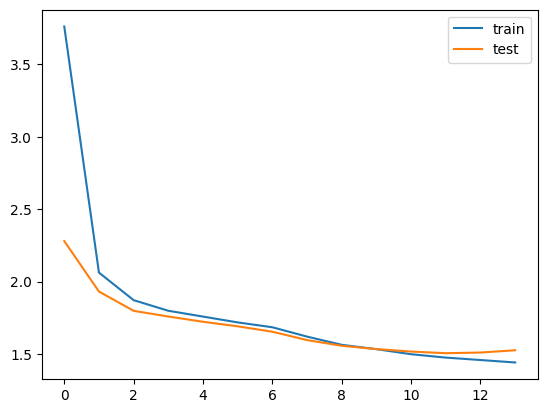

In [77]:
# Plot of Training and Validation loss
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [41]:
# From the plot, we can infer that validation loss has increased after epoch 14 for 2 successive epochs. Hence, training is stopped at epoch 19.

In [42]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index 

In [43]:
with open('reverse_target_word_index.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(reverse_target_word_index, file)
with open('reverse_source_word_index.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(reverse_source_word_index, file)
with open('target_word_index.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(target_word_index, file)

In [56]:
# Inference
# Set up the inference for the encoder and decoder:

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [45]:
with open('encoder_model_custom_attention.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(encoder_model, file)

In [53]:
decoder_model.save('decoder_model_custom_attention.h5')

In [46]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [47]:
# Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [48]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [49]:
# Summaries generated by the model:

In [79]:
x_tr[i]

array([ 24,  94, 205, 280, 352,  12, 310, 426, 109,  83,  45,  18, 125,
       515,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0])

In [50]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: son allergies item loves convenience feel good giving taste great 
Original summary: my loves them 
1/1 [==============================] - 0s 47ms/step
Predicted summary:  great


Review: use like asian dishes least week love product fast shipping usual would buy 
Original summary: sauce 
1/1 [==============================] - 0s 47ms/step
Predicted summary:  great


Review: reason amazon would ship sent got enjoy good chips amazon shipping thing would order online 
Original summary: great chips 
1/1 [==============================] - 0s 47ms/step
Predicted summary:  great


Review: love chips delicious hard eat one bag flavors taste favorite flavor cheese ones go try delicious 
Original summary: pop delicious 
1/1 [==============================] - 0s 61ms/step
Predicted summary:  great


Review: expensive worth yet find marinade one add garlic vegetables choice mix sauce whatever meat choose two days believe get worth every 
Original summary: but it 
1/1 [====================